# Simulation of a prism applied to a Non-linear inverse problem

## Importing libraries

In [1]:
%matplotlib inline
from fatiando.gridder import regular, spacing
from fatiando.mesher import Prism
from fatiando.utils import ang2vec
from fatiando.gravmag import prism
from fatiando.constants import CM, T2NT
import numpy as np
import matplotlib.pyplot as plt
from visual import histeq

## Prism parameters

### Dimension of the prism

In [2]:
dimx = 5.  # in mm
dimy = 5.
dimz = 5.

In [3]:
Lx = 1e-3*dimx

In [4]:
Ly = 1e-3*dimy

In [5]:
Lz = 1e-3*dimz

### Sensor-to-sample distance

In [6]:
voo = 500.
dist = voo*1e-6
sts = dist + (0.5*Lz) 

## Parameters for the observation coordinate

In [7]:
Nx = 50
Ny = 50
shape = (Nx,Ny)

In [8]:
xmax = 1e-3*6.
xmin = -xmax
ymax = 1e-3*6.
ymin = -ymax

area = [xmin,xmax,ymin,ymax]

In [9]:
x,y,z = regular(area,shape, -sts)

## Generating the sample

In [10]:
intensity = 0.1
inclination = 90.
declination = 0.

In [11]:
mag = ang2vec(intensity,inclination,declination)

In [12]:
sample = [Prism(-0.5*Lx,0.5*Lx,-0.5*Ly,0.5*Ly,-0.5*Lz,0.5*Lz, props={'magnetization': mag})]

## Calculating the observed data

In [13]:
Bz = prism.bz(x,y,z,sample)

In [14]:
np.random.seed(seed=40)

std_noise = 0.00000005*np.max(np.abs(Bz))
#std_noise = 0.05 # in nT

r = np.random.normal(0.0, std_noise, Nx*Ny)

print '%.3f nT' % std_noise

0.000 nT


In [15]:
Bz_obs = Bz + r

## Calculating the predicted data

In [16]:
def pred_data(x,y,z,sample,intensity,inc,dec):
    '''
    Calculate the predicted data.
    '''
    m = intensity
    jx = np.cos(np.deg2rad(inc))*np.cos(np.deg2rad(dec))
    jy = np.cos(np.deg2rad(inc))*np.sin(np.deg2rad(dec))
    jz = np.sin(np.deg2rad(inc))
    bz = prism.kernelxz(x,y,z,sample[0])*jx+\
         prism.kernelyz(x,y,z,sample[0])*jy+\
         prism.kernelzz(x,y,z,sample[0])*jz
    bz *= CM*T2NT*m
    return  bz

In [17]:
Bz_pred = pred_data(x,y,z,sample,intensity,inclination,declination)

## Comparison between observed data and predicted data

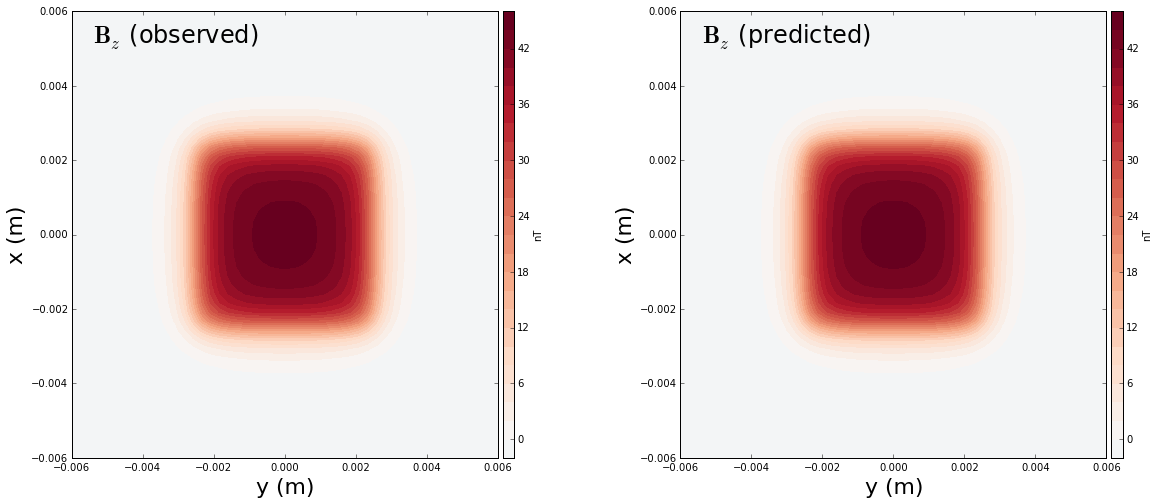

In [18]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
ranges = saturation_factor*np.abs([Bz_obs.max(), Bz_obs.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_obs.reshape(shape),30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (observed)', xy = (0.05, 0.93), 
             xycoords = 'axes fraction', fontsize=24)

plt.subplot(1,2,2)
ranges = saturation_factor*np.abs([Bz_pred.max(), Bz_pred.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_pred.reshape(shape), 30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (predicted)', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=24)

plt.show()


## Visualization of the data misfit

In [19]:
Nm = 50
m_range = np.linspace(0.001,1.,num=Nm)

In [20]:
Nh = 50
h_range = np.linspace(80.,600.,num=Nh)

In [21]:
m_range,h_range = np.meshgrid(m_range,h_range)

In [22]:
shape_phi = (Nm,Nh)

In [23]:
phi = []
for mi,hi in zip (m_range.ravel(),h_range.ravel()):
    dist = hi*1e-6
    h = dist + (0.5*Lz) 
    x0,y0,z0 = regular(area,shape, -h)
    Bz_pred_it = pred_data(x0,y0,z0,sample,mi,inclination,declination)
    res = Bz_obs - Bz_pred_it 
    phi.append(np.linalg.norm(res))

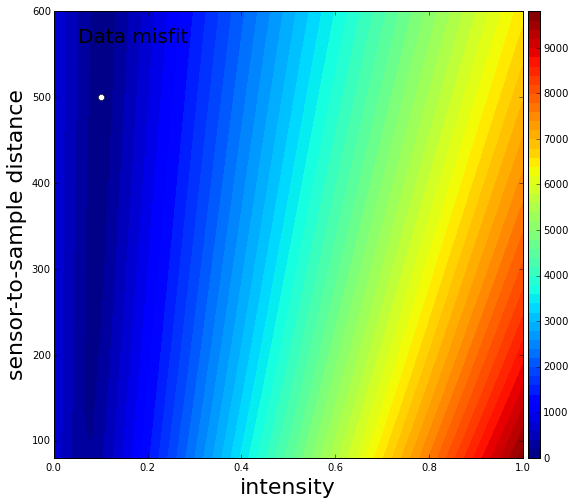

In [25]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(m_range, h_range, np.array(phi).reshape(shape_phi), 50)
plt.plot(intensity,voo,'wo')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('intensity', fontsize = title_font)
plt.ylabel('sensor-to-sample distance', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()